In [40]:
## Imports
import numpy as np
import torch
from PIL import Image
import os.path
import argparse
from pathlib import Path
import cv2
import heapq
from torch.nn import functional as F
from torch.utils.data import DataLoader
import tqdm
import einops
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from utils.factory import create_model_and_transforms, get_tokenizer
from utils.visualization import image_grid, visualization_preprocess
from prs_hook import hook_prs_logger
from matplotlib import pyplot as plt

In [41]:
## Hyperparameters

device = 'cuda:0'
pretrained = 'laion2b_s32b_b82k' # 'laion2b_s32b_b79k'
model_name = 'ViT-L-14' # 'ViT-H-14'
batch_size = 2 # only needed for the nn search
imagenet_path = '/datasets/ilsvrc_2024-01-04_1601/' # only needed for the nn search

In [42]:
## Loading Model

model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device)

Model parameters: 427,616,513
Context length: 77
Vocab size: 49408
Len of res: 24


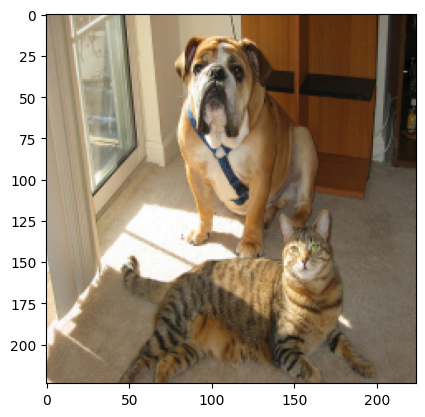

In [43]:
## Load image

image_pil = Image.open('images/catdog.png')
image = preprocess(image_pil)[np.newaxis, :, :, :]
_ = plt.imshow(image_pil)

In [44]:
## Run the image:
prs.reinit()
with torch.no_grad():
    representation = model.encode_image(image.to(device), 
                                        attn_method='head', 
                                        normalize=False)
    attentions, mlps = prs.finalize(representation)  # attentions: [1, 32, 257, 16, 1024], mlps: [1, 33, 1024]

## Visualize token decomposition

In [10]:
## Get the texts
lines = ['An image of a dog', 'An image of a cat']
texts = tokenizer(lines).to(device)  # tokenize
class_embeddings = model.encode_text(texts)
class_embedding = F.normalize(class_embeddings, dim=-1)

An image of a dog


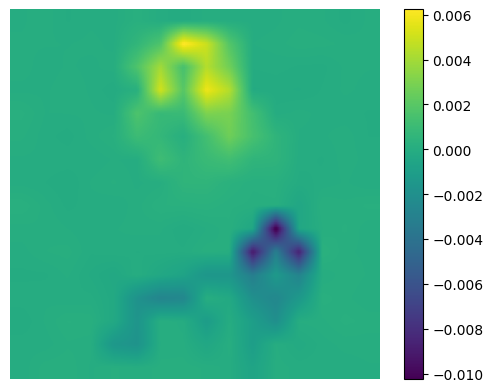

An image of a cat


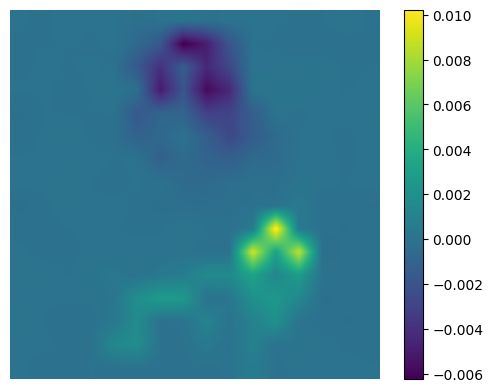

In [11]:
attention_map = attentions[0, :, 1:, :].sum(axis=(0,2)) @ class_embedding.T

# An image of a dog:
attention_map = F.interpolate(einops.rearrange(attention_map, '(B N M) C -> B C N M', N=16, M=16, B=1), 
                                  scale_factor=model.visual.patch_size[0],
                                  mode='bilinear').to(device)
attention_map = attention_map[0].detach().cpu().numpy()
print(lines[0])
plt.imshow(attention_map[0] - np.mean(attention_map,axis=0))

v = attention_map[0] - attention_map[1] # np.mean(attention_map,axis=0)
min_ = min((attention_map[0] - attention_map[1]).min(), (attention_map[1] - attention_map[0]).min())
max_ = max((attention_map[0] - attention_map[1]).max(), (attention_map[1] - attention_map[1]).max())
v = v - min_
v = np.uint8((v / (max_-min_))*255)
high = cv2.cvtColor(cv2.applyColorMap(v, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
plt.colorbar()
plt.axis('off')
plt.show()
print(lines[1])
plt.imshow(attention_map[1] - np.mean(attention_map,axis=0),)

v = attention_map[1] - attention_map[0]
v = v - min_
v = np.uint8((v / (max_-min_))*255)
high = cv2.cvtColor(cv2.applyColorMap(v, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
plt.colorbar()
plt.axis('off')
plt.show()

## Show Nearest Neighbors

In [45]:
## Create the pool for the nn search

ds_vis = ImageNet(root=imagenet_path, split="val", transform=visualization_preprocess) # For showing images
ds = ImageNet(root=imagenet_path, split="val", transform=preprocess) # For running the model
dataloader = DataLoader(
    ds, batch_size=batch_size, shuffle=False, num_workers=8
)

In [53]:
## Define the head for which you want to search (e.g. "counting" head)

search_head = (20, 4) # (layer, head), try also - (23, 8) for color head

query = attentions[0, search_head[0], :, search_head[1]].sum(axis=0)

In [54]:
## Go over and search greedily (alternatively, use the precomputed values)

db = [(-float("inf"), None) for _ in range(15)]
for index, (images, _) in tqdm.tqdm(enumerate(dataloader)):
    # For a quick search, we skip 49/50 batches. The results are therefore different from the paper. 
    # Please remove the next two lines or use the precomputed attentions for better results 
    if index % 50 != 0:
        continue
    images = images.to(device)
    with torch.no_grad():
        prs.reinit()
        current_representation = model.encode_image(images, 
                                                    attn_method='head', 
                                                    normalize=False)
        current_attentions, _ = prs.finalize(current_representation)  # attentions: [batch_size, layers, tokens, heads, repr_size]
        scores = current_attentions[:, search_head[0], :, search_head[1]].sum(axis=1) @ query
        for i in range(min(batch_size, images.shape[0])):
            heapq.heappushpop(db, (scores[i], batch_size * index + i))
db = sorted(db, key=lambda x: -x[0])

25000it [12:08, 34.30it/s]


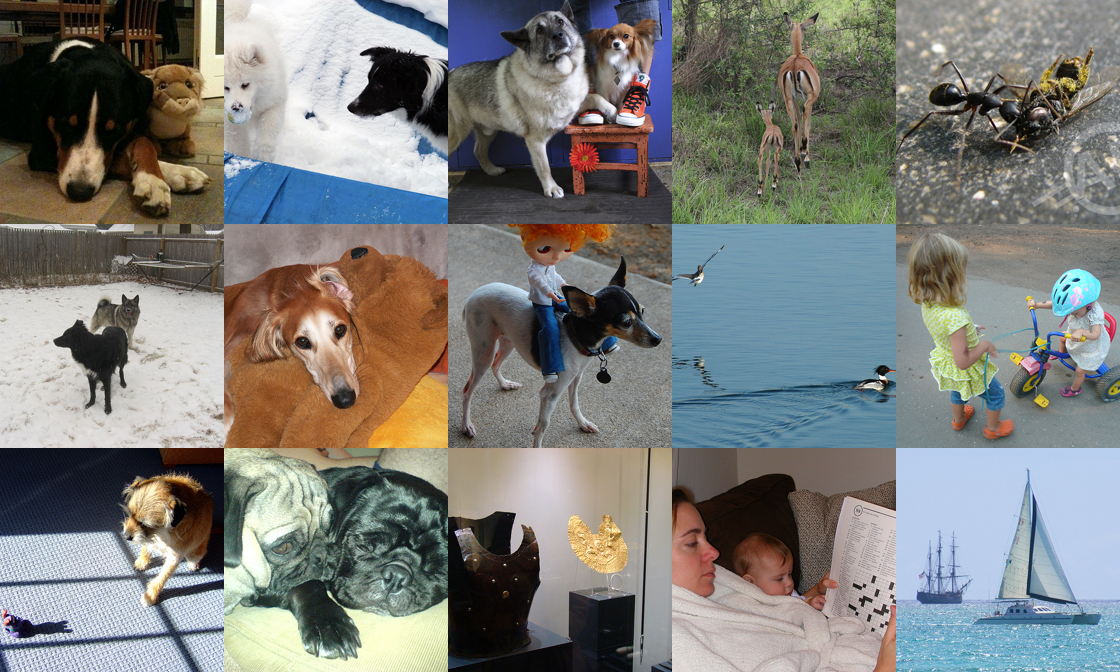

In [57]:
# Plot the top images in a grid:
images = []
for image_index in db:
    images.append(ds_vis[image_index[1]][0])
image_grid(images, 3, 5)